In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
project_dir_path = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers'

#### Load Packages

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier
import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### set the *q-value* threshold & *comparison type*

In [4]:
qval_thresh = 0.05
comparison_X = 'ATB_v_LTBI'

Need # datasets used in each study to normalize edge weights

In [5]:
num_datasets_per_comparison = {
'ATB_v_LTBI': 16,
'ATB_v_HC' : 15,
'ATB_v_OD': 10,
'LTBI_v_HC': 9}

Create directory for figures

In [6]:
figures_dir_path = f'{project_dir_path}/Figures/Notebook 5'
if not os.path.exists(figures_dir_path):
    os.makedirs(figures_dir_path)

Specify directory to the *pooled* differential gene expression data

In [7]:
diff_exp_data_dir = f'{project_dir_path}/Data/Pooled Differential Gene Expression/'

Create directory for pickling objects

In [8]:
pickled_objects_dir = f'{project_dir_path}/Data/Pickled Files/'
if not os.path.exists(pickled_objects_dir):
    os.makedirs(pickled_objects_dir)
    
#for degree series
if not os.path.exists(pickled_objects_dir + f'Network Files/degree series'):
    os.makedirs(pickled_objects_dir + f'Network Files/degree series')

#for weighted degree series
if not os.path.exists(pickled_objects_dir + f'Network Files/weighted degree series'):
    os.makedirs(pickled_objects_dir + f'Network Files/weighted degree series')                

#for eigenvector centrality series
if not os.path.exists(pickled_objects_dir + f'Network Files/eigenvector centrality series'):
    os.makedirs(pickled_objects_dir + f'Network Files/eigenvector centrality series')
                
#for networks
if not os.path.exists(pickled_objects_dir + f'Network Files/networks'):
    os.makedirs(pickled_objects_dir + f'Network Files/networks')
                
#for mean logFC series
if not os.path.exists(pickled_objects_dir + f'Network Files/mean logFC network nodes series'):
    os.makedirs(pickled_objects_dir + f'Network Files/mean logFC network nodes series')

Set parameters for plotting

In [9]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [10]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, linecolor):
    
    #convert Counter dict to series
    edge_weight_distr_series = pd.Series(edge_weight_distr_counter_dict).sort_index()
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = edge_weight_distr_series.index
    edge_weight_count = edge_weight_distr_series.values
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'white' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index <= -3] , edge_weight_count_norm[edge_weight_distr_series.index <= -3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index >= 3] , edge_weight_count_norm[edge_weight_distr_series.index >= 3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.plot(edge_weight_values , edge_weight_count_norm, color = linecolor , linewidth = 2.5)
    
    # calculate the number of the edges that had weight <= -3
    negative_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index <= -3].sum()
    
    # calculate the number of the edges that had weight >= 3
    positive_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index >= 3].sum()

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights \n (Num Edges <= -3: {negative_edge_weights_for_network}) \n (Num Edges >= 3: {positive_edge_weights_for_network})' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

## [1] Compute Edges (and corresponding weights) from pooled logFC matrix

In [11]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

# read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

# Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
# +1 if logFC > 0
#  0 if logFC = 0
# -1 if logFC < 0

# store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

# replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

# convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

# compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
# Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$
# multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

# the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

# DISTRIBUTION OF EDGE WEIGHTS

#number of rows / columns
num_genes = np.shape(network_edge_weight_matrix)[0]

# retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]

#convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

In [12]:
network_edge_weight_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 12,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8)

In [13]:
np.shape(network_edge_weight_matrix)

(30641, 30641)

In [14]:
network_edge_weight_matrix_labels.head()

0        LINC00113
1           SPOCK2
2           HS3ST5
3    CTD-2201I18.1
4          HSFY1P1
dtype: object

In [15]:
np.shape(network_edge_weight_matrix_labels)

(30641,)

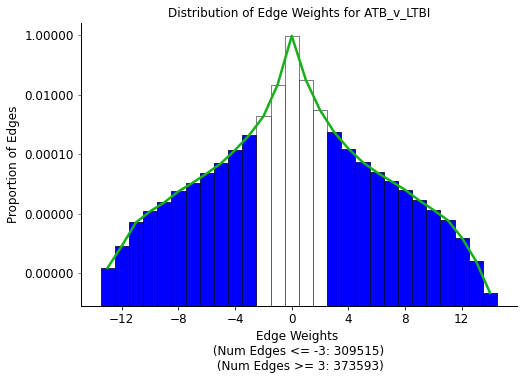

In [16]:
fig , ax = plt.subplots()

plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, f'Distribution of Edge Weights for {comparison_X}', 'xkcd:green')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_distribution_of_edge_weights_in_network.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### minimum/maximum edge weights

In [17]:
np.min(network_edge_weight_matrix)

-13

In [18]:
np.max(network_edge_weight_matrix)

14

## [2] Construct NetworkX graph from edge weight matrix

#### Retrieve the indices for the upper-triangular part of the matrix, normalize edge weights & construct list of edges

Have to (1) retrieve the edges from the upper-triangle of the matrix, (2) convert all to positive edge weights & (3) divide by the number of datasets

In [19]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -3 OR >= 3
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 3

#get the indices for the elements in the upper triangle where elements (edge weights) <= -3 OR >= 3
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#get the normalization factor (number of datasets used to construct edge weights = maximum possible weight)
edge_weight_norm_factor = float(num_datasets_per_comparison[comparison_X])

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -3 OR >= 3
G_edge_list = [ ( network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], (float(abs(network_edge_weight_matrix[node_i, node_j]))/edge_weight_norm_factor) ) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [20]:
G_edge_list[0:10]

[('SPOCK2', 'SPOCK2', 0.75),
 ('SPOCK2', 'ZNF439', 0.25),
 ('SPOCK2', 'TIFA', 0.1875),
 ('SPOCK2', 'E2F5', 0.375),
 ('SPOCK2', 'GMFG', 0.1875),
 ('SPOCK2', 'TRPM2', 0.1875),
 ('SPOCK2', 'CLYBL', 0.1875),
 ('SPOCK2', 'ZNF551', 0.1875),
 ('SPOCK2', 'CLEC2D', 0.4375),
 ('SPOCK2', 'SLPI', 0.375)]

In [21]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -3 OR >= 3)

683108

#### Construct NetworkX graph from list of Edges

In [22]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [23]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2670
Number of edges: 683108
Average degree: 511.6914


Pickle the network for downstream analysis

In [24]:
nx.write_gpickle(G , pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')

## Visualize network

Use **Spring Layout** to set the positions of the nodes

In [25]:
pos = nx.spring_layout(G , k = 0.35 , weight = 'weight' , iterations = 100)

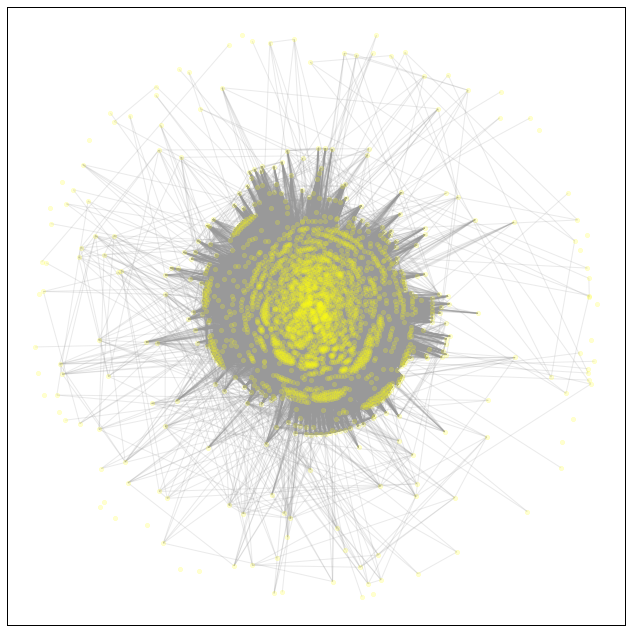

In [26]:
fig , ax = plt.subplots()

nx.draw_networkx(
    G, 
    pos = pos, 
    ax = ax,
    node_size = 20, 
    node_color = 'xkcd:yellow',
    edge_color = "0.6",
    alpha = 0.2, 
    with_labels = False)

fig = plt.gcf()
fig.set_size_inches(9.0, 9.0)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_network_visualization.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### *Function* to color a subset of nodes differently

In [27]:
def draw_graph_and_color_subset_nodes(G, nodes_in_group, ax):

    '''
    This function takes in a graph, list of a subset of nodes and axis object,
    then draws the network with the subset of nodes colored seperately from the 
    rest of the nodes in the network
    '''

    #draw nodes NOT in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(25)
        elif node in nodes_in_group:
            size_map.append(0)

    nx.draw_networkx(
        G, 
        ax = ax,
        pos=pos, 
        node_size=size_map, 
        node_color = 'xkcd:grey',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=0.25, 
        with_labels=False)

    #draw nodes that ARE in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(0)
        elif node in nodes_in_group:
            size_map.append(25)

    nx.draw_networkx(
        G, 
        pos=pos, 
        ax = ax,
        node_size=size_map, 
        node_color = 'xkcd:black',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=0.7, 
        with_labels=False)

## [3] Centrality of Nodes from NetworkX graph

Get a series of the **Degree** for each node

In [28]:
node_list = [node_deg[0] for node_deg in list(G.degree())]
degree_list = [node_deg[1] for node_deg in list(G.degree())]
degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)

Get a series of the **Weighted Degree** for each node

In [29]:
node_list = [node_deg[0] for node_deg in list(G.degree(weight = 'weight'))]
degree_list = [node_deg[1] for node_deg in list(G.degree(weight = 'weight'))]
weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)

Get a series of the **Eigenvector Centrality** for each node

In [30]:
eigenvector_centrality_series = pd.Series(nx.eigenvector_centrality(G, weight = 'weight')).sort_values(ascending = False) #takes edge weight into account

Pickle **Degree**, **Weighted Degree** and **Eigenvector Centrality** series for comparison with other networks

In [31]:
degree_series.to_pickle(pickled_objects_dir + f'Network Files/degree series/{comparison_X}.pkl')
weighted_degree_series.to_pickle(pickled_objects_dir + f'Network Files/weighted degree series/{comparison_X}.pkl')
eigenvector_centrality_series.to_pickle(pickled_objects_dir + f'Network Files/eigenvector centrality series/{comparison_X}.pkl')

Plot the distibution of **centrality** values for all nodes

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


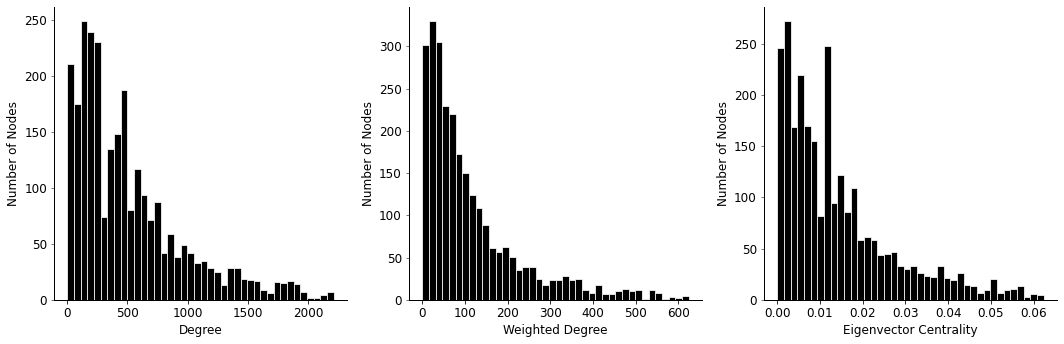

In [32]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

#DEGREE CENTRALITY
ax1.hist(degree_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax1.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax1.set_xlabel(f'Degree' , fontsize = 12, color = 'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(False)
ax1.tick_params(labelcolor = 'k')
ax1.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax1.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#WEIGHTED DEGREE CENTRALITY
ax2.hist(weighted_degree_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax2.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax2.set_xlabel(f'Weighted Degree' , fontsize = 12, color = 'k')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.tick_params(labelcolor = 'k')
ax2.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax2.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
#EIGENVECTOR CENTRALITY
ax3.hist(eigenvector_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax3.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax3.set_xlabel(f'Eigenvector Centrality' , fontsize = 12, color = 'k')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.grid(False)
ax3.tick_params(labelcolor = 'k')
ax3.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax3.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(15, 5.0)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_network_centrality_distribution.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


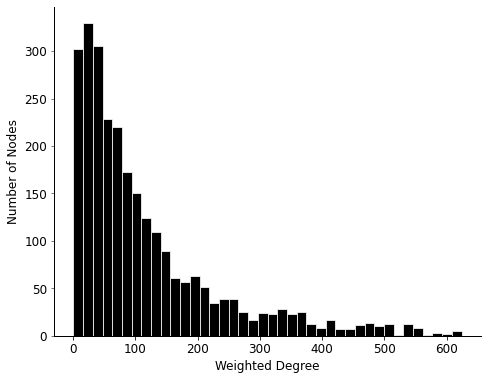

In [33]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 1, figure=fig)

ax2 = fig.add_subplot(gs[0])

#WEIGHTED DEGREE CENTRALITY
ax2.hist(weighted_degree_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax2.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax2.set_xlabel(f'Weighted Degree' , fontsize = 12, color = 'k')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.tick_params(labelcolor = 'k')
ax2.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax2.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(7, 5.5)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_network_weighted_degree_centrality_distribution.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [34]:
degree_series.head(n=5)

FCGR1B    2210
IL7R      2203
IFITM3    2203
CCR7      2203
FBXO6     2203
dtype: int64

In [35]:
weighted_degree_series.head(n=5)

FCGR1B    624.0625
FBXO6     620.1875
IFITM3    620.1875
IL7R      620.1875
CCR7      620.1875
dtype: float64

In [36]:
eigenvector_centrality_series.head(n=5)

FCGR1B    0.062350
IL7R      0.062043
FBXO6     0.062043
CCR7      0.062043
IFITM3    0.062043
dtype: float64

How does the ranking of centrality values between **Weighted Degree** and **Eigenvector** centrality compare?

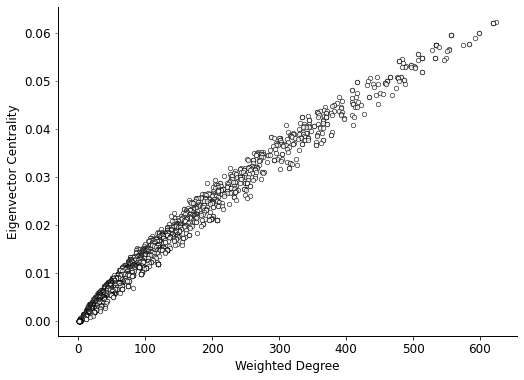

In [37]:
fig , ax = plt.subplots()

ax.scatter(weighted_degree_series[eigenvector_centrality_series.index], eigenvector_centrality_series , color = 'white' , linewidth=0.75 , edgecolor = 'black' , s = 20 , alpha = 0.75)

#ax.set_title('Degree vs. Eigenvector Centrality', fontsize = 10, color = 'k')
ax.set_ylabel('Eigenvector Centrality', fontsize = 12, color = 'k')
ax.set_xlabel('Weighted Degree' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_eigenvector_v_weighted_degree.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [38]:
for edge in weighted_degree_series.head(n=10).index:
    print(edge)

FCGR1B
FBXO6
IFITM3
IL7R
CCR7
SLC38A1
SMARCD3
ABLIM1
SCO2
VAMP5


Where are the **100** most **central** nodes located in the network?

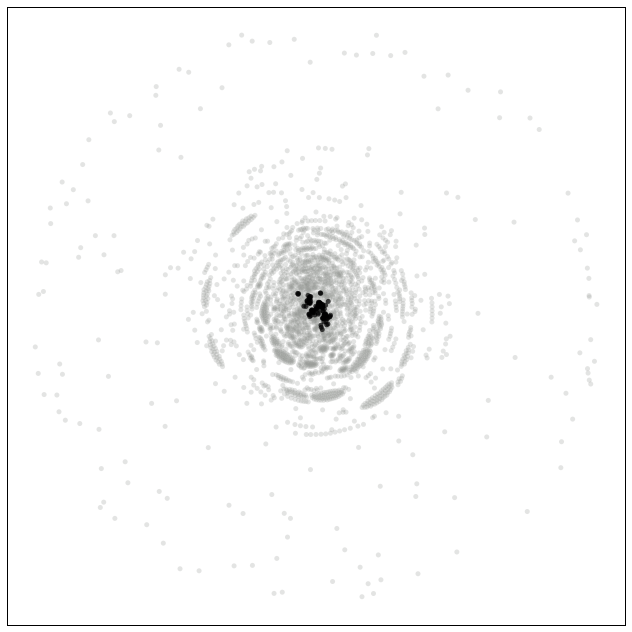

In [39]:
central_nodes = set(weighted_degree_series[0:100].index)

fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, central_nodes, ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 9.0)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_top_100_weighted_nodes_in_network_visualization.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

## [4] Get mean $log_2$(Fold Change) for all genes in network

Create a series that stores the mean $log2(FC)$ across datasets from the $log2(FC)$ matrix (rows = genes & columns = datasets)

when averaging $log2(FC)$ across datasets, **include all** datasets (columns) (including non-zero & zero)

- some datasets in which logFC for a gene = 0 are due to **q-value** threshold or **logFC** threshold or both

In [40]:
genes_in_network = list(G.nodes()) #get all nodes in the network
mean_logFC_series = pd.Series(index = genes_in_network) #create series

for gene_i in mean_logFC_series.index:
    
    #use code below to calculate average logFC for gene across ALL datasets/studies
    gene_i_mean_logFC = diff_gene_exp_df.loc[gene_i , :].mean()
    
    #append to series
    mean_logFC_series[gene_i] = gene_i_mean_logFC
    
mean_logFC_series.sort_values(inplace = True, ascending = False)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [41]:
mean_logFC_series.head(n = 5)

C1QB        2.055265
SERPING1    2.013491
FCGR1B      1.955971
ANKRD22     1.907299
FCGR1A      1.900241
dtype: float64

In [42]:
mean_logFC_series.tail(n = 5)

FCGBP    -0.968003
S1PR1    -0.996190
CCR7     -1.010705
NELL2    -1.032864
GPR183   -1.075041
dtype: float64

In [43]:
np.shape(mean_logFC_series)

(2670,)

#### Plot the distribution of mean logFC for genes (nodes) in the network

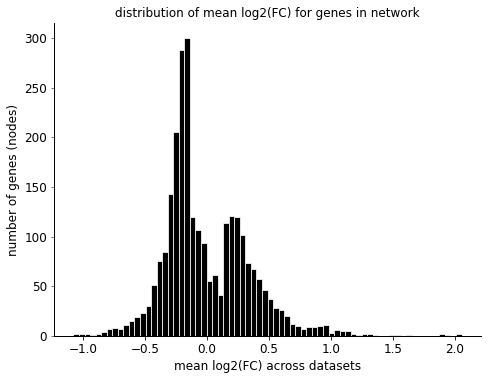

In [44]:
fig , ax = plt.subplots()

n, bins, patches = ax.hist(mean_logFC_series , bins = 70, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax.set_title(f'distribution of mean log2(FC) for genes in network', fontsize = 12, color = 'k')
ax.set_ylabel(f'number of genes (nodes)', fontsize = 12, color = 'k')
ax.set_xlabel('mean log2(FC) across datasets' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.0, 5.5)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X}_network_logFC_distribution.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

Pickle **mean $log2(FC)$** series for comparison with other networks and downstream analysis

In [45]:
mean_logFC_series.to_pickle(pickled_objects_dir + f'Network Files/mean logFC network nodes series/{comparison_X}.pkl')